### Importing the necessary libraries

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy

### Loading Image Data:

In [13]:
# Creating an iterable object for your train set:
training_data_generator = ImageDataGenerator(rescale = 1.0/255.0, zoom_range=0.1, rotation_range=25, width_shift_range=0.05, height_shift_range=0.05)

DIRECTORY = "Covid19-dataset/train"
CLASS_MODE = "categorical"
COLOR_MODE = "grayscale"
TARGET_SIZE = (256,256)
BATCH_SIZE = 32

training_iterator = training_data_generator.flow_from_directory(DIRECTORY,class_mode=CLASS_MODE,color_mode=COLOR_MODE,target_size=TARGET_SIZE,batch_size=BATCH_SIZE)

# Creating an iterable object for your train set:
validation_data_generator = ImageDataGenerator()
validation_iterator = validation_data_generator.flow_from_directory(DIRECTORY,class_mode=CLASS_MODE,color_mode=COLOR_MODE,target_size=TARGET_SIZE,batch_size=BATCH_SIZE)

#print(training_data_generator.__dict__)

Found 251 images belonging to 3 classes.
Found 251 images belonging to 3 classes.


### Building the Model:

In [22]:
model = Sequential()

# Adding input layer:
model.add(tf.keras.Input(shape=(256, 256, 1)))

# Adding convolutional hidden layers with relu functions
# Adding maxpooling layers as well:
model.add(layers.Conv2D(5, 5, strides=3, activation="relu")) 
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
model.add(layers.Dropout(0.1))
model.add(layers.Conv2D(3, 3, strides=1, activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())

# Adding output layer:
model.add(layers.Dense(3,activation="softmax"))

### Compiling the model

In [27]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001), 
              loss=tf.keras.losses.CategoricalCrossentropy(), 
              metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.AUC()],)
print(model.summary())

# early stopping implementation
es = EarlyStopping(monitor='val_auc', mode='min', verbose=1, patience=20)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 84, 84, 5)         130       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 42, 42, 5)         0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 42, 42, 5)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 40, 40, 3)         138       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 20, 20, 3)         0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 20, 20, 3)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1200)             

### Evaluating your model

In [28]:
history = model.fit(training_iterator,steps_per_epoch=training_iterator.samples/BATCH_SIZE, epochs=5,
            validation_data=validation_iterator,
            validation_steps=validation_iterator.samples/BATCH_SIZE, callbacks=[es])

Epoch 1/5
8/7 [==============================] - 4s 489ms/step - loss: 0.4973 - categorical_accuracy: 0.7888 - auc_5: 0.9299 - val_loss: 23.4129 - val_categorical_accuracy: 0.9084 - val_auc_5: 0.9337
Epoch 2/5
8/7 [==============================] - 3s 437ms/step - loss: 0.5024 - categorical_accuracy: 0.8127 - auc_5: 0.9295 - val_loss: 23.5929 - val_categorical_accuracy: 0.9163 - val_auc_5: 0.9373
Epoch 3/5
8/7 [==============================] - 4s 448ms/step - loss: 0.4279 - categorical_accuracy: 0.8327 - auc_5: 0.9489 - val_loss: 28.1454 - val_categorical_accuracy: 0.8845 - val_auc_5: 0.9161
Epoch 4/5
8/7 [==============================] - 4s 441ms/step - loss: 0.4498 - categorical_accuracy: 0.8406 - auc_5: 0.9440 - val_loss: 25.6009 - val_categorical_accuracy: 0.9163 - val_auc_5: 0.9373
Epoch 5/5
8/7 [==============================] - 4s 486ms/step - loss: 0.4410 - categorical_accuracy: 0.8247 - auc_5: 0.9449 - val_loss: 27.8746 - val_categorical_accuracy: 0.8924 - val_auc_5: 0.9221


### Visualizing the accuracy of the model

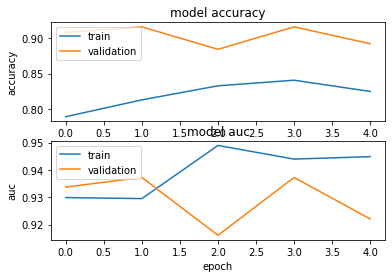

In [29]:
# plotting categorical and validation accuracy over epochs
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(history.history['categorical_accuracy'])
ax1.plot(history.history['val_categorical_accuracy'])
ax1.set_title('model accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.legend(['train', 'validation'], loc='upper left')

ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(history.history['auc_5'])
ax2.plot(history.history['val_auc_5'])
ax2.set_title('model auc')
ax2.set_xlabel('epoch')
ax2.set_ylabel('auc')
ax2.legend(['train', 'validation'], loc='upper left')

plt.show()

In [30]:
test_steps_per_epoch = numpy.math.ceil(validation_iterator.samples / validation_iterator.batch_size)
predictions = model.predict(validation_iterator, steps=test_steps_per_epoch)
test_steps_per_epoch = numpy.math.ceil(validation_iterator.samples / validation_iterator.batch_size)
predicted_classes = numpy.argmax(predictions, axis=1)
true_classes = validation_iterator.classes
class_labels = list(validation_iterator.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)   

cm=confusion_matrix(true_classes,predicted_classes)
print(cm)

              precision    recall  f1-score   support

       Covid       0.44      0.41      0.43       111
      Normal       0.31      0.36      0.33        70
   Pneumonia       0.31      0.30      0.31        70

    accuracy                           0.37       251
   macro avg       0.36      0.36      0.36       251
weighted avg       0.37      0.37      0.37       251

[[46 37 28]
 [27 25 18]
 [31 18 21]]
